In [42]:
import numpy as np 
import pandas as pd 
import json
import os
import cv2 
import PIL 
import gc
import psutil
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from tensorflow import set_random_seed
from tqdm import tqdm
from math import ceil

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop
from keras.layers import BatchNormalization

from tqdm import tqdm


In [2]:
SEED = 7
np.random.seed(SEED) 
set_random_seed(SEED)

# take in data
df_train = pd.read_csv("../input/train.csv") 
df_test  = pd.read_csv("../input/test.csv")


# point data to file types
df_train.id_code = df_train.id_code.apply(lambda x: x+".png")
df_test.id_code  = df_test.id_code.apply(lambda x: x+".png")
df_train['diagnosis'] = df_train['diagnosis'].astype('str')


In [3]:
IMG_DIM      = 300
BATCH_SIZE   = 32
CHANNEL_SIZE = 3
NUM_EPOCHS   = 12
# FREEZE_LAYERS = 2  # freeze the first this many layers for training
NUM_CLASSES = df_train['diagnosis'].nunique()

class_names = {"0":"No DR", "1":"Mild", "2":"Moderate", "3":"Severe", "4":"Proliferative DR"}

df_train.columns, df_test.columns, NUM_CLASSES


(Index(['id_code', 'diagnosis'], dtype='object'),
 Index(['id_code'], dtype='object'),
 5)

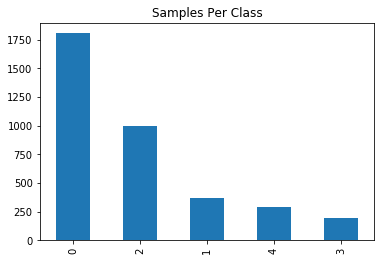

In [4]:
df_train['diagnosis'].value_counts().plot(kind='bar');
plt.title('Samples Per Class');


In [32]:
def create_resnet(img_dim, CHANNELS, n_class):
    input_tensor=Input(shape=(img_dim, img_dim, CHANNELS))
  
    base_model = ResNet50(weights=None, include_top=False, input_tensor=input_tensor)
    base_model.load_weights('../resnet50/jam.h5')
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.2)(x)
    x = Dense(1024, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = Dense(512, activation=relu)(x)
    x = Dropout(0.15)(x)
    x = BatchNormalization()(x)
    output_layer = Dense(n_class, activation='softmax', name="Output_Layer")(x)
    model_resnet = Model(input_tensor, output_layer)
    
    return model_resnet

model_resnet=create_resnet(IMG_DIM, CHANNEL_SIZE, NUM_CLASSES)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [33]:
# todo: don't think this is thinking of frozen layers
for layers in model_resnet.layers:
    layers.trainable = True

lr = 1e-3
optimizer = rmsprop(lr=lr, decay=0.1)
model_resnet.compile(optimizer=optimizer, loss=keras.losses.categorical_crossentropy,  metrics=['accuracy'])
# model_resnet.summary()
gc.collect()

789

In [40]:
# Run on test data
model_resnet.load_weights('../resnet50/jam.h5')

test_df = pd.read_csv('../input/test.csv')
test_df.head()
test_df['id_code'] = test_df['id_code'].apply(lambda x:  x + '.png')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_generator = test_datagen.flow_from_dataframe(  dataframe=test_df, 
                                                    directory="../input/test_images/", 
                                                    x_col='id_code', 
                                                    y_col=None,
                                                    shuffle=False,
                                                    class_mode=None,
                                                    batch_size=BATCH_SIZE,
                                                    target_size=(IMG_DIM,IMG_DIM)
                                                 )

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size


predict_output=model_resnet.predict_generator(test_generator,
                                                steps=STEP_SIZE_TEST,
                                                verbose=1)

ValueError: You are trying to load a weight file containing 106 layers into a model with 110 layers.

In [ ]:
# Save results in submission file
y_test= np.argmax(predict_output,axis=1)
print(y_test)

test_df = pd.read_csv('../input/test.csv')
print(test_df)
print(y_test.shape)
test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)
print(test_df)